# Federated IDS (4 clients) with TenSEAL (CKKS) encrypted weight aggregation


In [ ]:
!pip install TenSEAL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

try:
    import tenseal as ts
except Exception as e:
    print('tenseal not available. Install tenseal (pip install tenseal) to use encrypted aggregation.')
    ts = None


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

SAMPLING_FRACTION = 0.2

# -----------------------------
DATA_DIR = '/content/drive/MyDrive/College /MachineLearningCVE'
csv_files = glob.glob(os.path.join(DATA_DIR, '*.csv'))
if not csv_files:
    raise FileNotFoundError(f'No CSV files found in {DATA_DIR}. Please upload them and re-run.')

print(f'Found {len(csv_files)} CSV files. Reading and concatenating...')
dfs = [pd.read_csv(file, low_memory=False) for file in csv_files]
df = pd.concat(dfs, ignore_index=True)
print('Raw combined shape:', df.shape)

if SAMPLING_FRACTION < 1.0:
    df_sampled = df.sample(frac=SAMPLING_FRACTION, random_state=42)
    print(f'Dataset sampled to {SAMPLING_FRACTION*100:.1f}% of original size.')
    print('Sampled shape:', df_sampled.shape)
else:
    df_sampled = df
    print('No sampling applied (SAMPLING_FRACTION is 1.0).')

df = df_sampled
if 'Label' in df.columns:
    label_col = 'Label'
elif ' Label' in df.columns:
    label_col = ' Label'
else:
    label_col = df.columns[-1]
    print('Using last column as label:', label_col)

non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
non_numeric = [c for c in non_numeric if c != label_col]
df = df.drop(columns=non_numeric, errors='ignore')

unique_labels = df[label_col].unique()
label_mapping = {}
current_index = 0
for lbl in unique_labels:
    lbl_str = str(lbl).strip().upper()
    if lbl_str.startswith("BENIGN"):
        label_mapping[lbl] = 0
    else:
        current_index += 1
        label_mapping[lbl] = current_index

df[label_col] = df[label_col].map(label_mapping)
df = df.dropna(subset=[label_col])


X = df.drop(columns=[label_col]).values
y = df[label_col].values

X = np.where(np.isinf(X), np.nan, X)
col_means = np.nanmean(X, axis=0)
inds = np.where(np.isnan(X))
X[inds] = np.take(col_means, inds[1])

scaler = StandardScaler()
X = scaler.fit_transform(X)
num_classes = len(np.unique(y))

X_fl_train, X_test_full, y_fl_train, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('--- Data Summary ---')
print(f'Total features shape after sampling/cleaning: {X.shape}')
print(f'FL Training Data Shape: {X_fl_train.shape}')
print(f'Global Test Data Shape: {X_test_full.shape}')
print(f'Number of Classes: {num_classes}')
print("Fine-grained label distribution (FL Training Set):")
print(pd.Series(y_fl_train).value_counts())
print('Preprocessing and Global Split complete.')

Found 8 CSV files. Reading and concatenating...
Raw combined shape: (2830743, 79)
Dataset sampled to 20.0% of original size.
Sampled shape: (566149, 79)
--- Data Summary ---
Total features shape after sampling/cleaning: (566149, 78)
FL Training Data Shape: (452919, 78)
Global Test Data Shape: (113230, 78)
Number of Classes: 15
Fine-grained label distribution (FL Training Set):
0     363394
4      37011
2      25773
3      20410
7       1676
1       1270
8        973
10       896
5        847
6        317
11       234
9        105
12         8
13         3
14         2
Name: count, dtype: int64
Preprocessing and Global Split complete.


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
!pip install -U imbalanced-learn


In [ ]:
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE


print("Original label distribution (FL Training Set):", Counter(y_fl_train))

TARGET_COUNT = 25000
current_counts = Counter(y_fl_train)
sampling_strategy = {}
for label, count in current_counts.items():
    if label != 0:  # Check if it's a minority class
        sampling_strategy[label] = max(count, TARGET_COUNT)
    else:
        sampling_strategy[label] = count

smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy, k_neighbors=1)
X_res_2d, y_res = smote.fit_resample(X_fl_train, y_fl_train)

print("After CONTROLLED SMOTE on FL Training Data:")
print(Counter(y_res))
print(f"Total samples for FL training after SMOTE: {len(y_res)}")

SEQUENCE_LENGTH = 1
X_res = X_res_2d.reshape(-1, SEQUENCE_LENGTH, X_res_2d.shape[1])
print(f'Reshaped X_res for LSTM: {X_res.shape}')


# Non-IID Split Function (Dirichlet)

def split_noniid(X, y, num_clients=4, alpha=0.5):
    np.random.seed(42)
    labels = np.unique(y)
    idx_per_label = {label: np.where(y == label)[0].tolist() for label in labels}
    clients_idx = {i: [] for i in range(num_clients)}

    for label, idxs in idx_per_label.items():
        np.random.shuffle(idxs)
        proportions = np.random.dirichlet([alpha] * num_clients)
        counts = (proportions * len(idxs)).astype(int)
        while counts.sum() < len(idxs):
            counts[np.argmax(proportions)] += 1
        ptr = 0
        for c in range(num_clients):
            cnt = counts[c]
            if cnt > 0:
                clients_idx[c].extend(idxs[ptr:ptr + cnt])
                ptr += cnt

    clients = []
    for c in range(num_clients):
        idcs = clients_idx[c]
        clients.append((X[idcs], y[idcs]))
    return clients

num_clients = 4
clients = split_noniid(X_res, y_res, num_clients=num_clients, alpha=0.5)

print("\n--- Client Data Distribution ---")
for i, (Xc, yc) in enumerate(clients):
    print(f"Client {i+1}: {len(yc)} samples | label distribution: {Counter(yc)}")
print('Client partitioning complete.')

Original label distribution (FL Training Set): Counter({np.int64(0): 363394, np.int64(4): 37011, np.int64(2): 25773, np.int64(3): 20410, np.int64(7): 1676, np.int64(1): 1270, np.int64(8): 973, np.int64(10): 896, np.int64(5): 847, np.int64(6): 317, np.int64(11): 234, np.int64(9): 105, np.int64(12): 8, np.int64(13): 3, np.int64(14): 2})
After CONTROLLED SMOTE on FL Training Data:
Counter({np.int64(0): 363394, np.int64(4): 37011, np.int64(2): 25773, np.int64(3): 25000, np.int64(8): 25000, np.int64(5): 25000, np.int64(7): 25000, np.int64(10): 25000, np.int64(1): 25000, np.int64(6): 25000, np.int64(11): 25000, np.int64(9): 25000, np.int64(13): 25000, np.int64(12): 25000, np.int64(14): 25000})
Total samples for FL training after SMOTE: 726178
Reshaped X_res for LSTM: (726178, 1, 78)

--- Client Data Distribution ---
Client 1: 96010 samples | label distribution: Counter({np.int64(0): 25464, np.int64(13): 18708, np.int64(14): 9450, np.int64(8): 7513, np.int64(4): 6948, np.int64(12): 5799, np.i

In [ ]:

class LSTM_IDS(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=15, num_layers=2):
        super().__init__()
        # input_dim is the feature count (78 in your case)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        last_hidden = hidden[-1, :, :]
        return self.classifier(last_hidden)

def get_model(input_dim, num_classes):
    """Returns an initialized LSTM_IDS model with the correct dimensions."""
    return LSTM_IDS(input_dim, output_dim=num_classes)

In [ ]:
def model_to_vector(state_dict):
    vec = []
    shapes = {}
    for k, v in state_dict.items():
        arr = v.cpu().numpy().ravel()
        shapes[k] = v.shape
        vec.append(arr)
    flat = np.concatenate(vec).astype(np.float64)
    return flat, shapes

def vector_to_model(state_dict_template, flat_vec, shapes):
    new_state = {}
    ptr = 0
    for k in state_dict_template.keys():
        num = int(np.prod(shapes[k]))
        slice_ = flat_vec[ptr:ptr+num]
        new_state[k] = torch.tensor(slice_.reshape(shapes[k]), dtype=state_dict_template[k].dtype)
        ptr += num
    return new_state

def create_tenseal_context():
    if ts is None:
        raise RuntimeError('tenseal not installed')
    ctx = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree=8192, coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 60])
    ctx.generate_galois_keys()
    ctx.global_scale = 2**40
    return ctx

def encrypt_vector(ctx, vec):
    return ts.ckks_vector(ctx, vec)

def decrypt_vector(enc_vec):
    return np.array(enc_vec.decrypt())


In [ ]:
def train_local(model, X_train, y_train, epochs=3, batch_size=64, lr=1e-3, device='cpu'):
    model = model.to(device)
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    for e in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()
    return model.state_dict()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import tenseal as ts
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def federated_train_with_encryption(clients, input_dim, num_classes,
                                    rounds=7, local_epochs=5, batch_size=32, device='cpu'):
    """
    Federated Learning with encryption, mini-batching, weighted loss, and improved stability.
    """
    print(f"Starting Federated Learning with Encryption — Rounds: {rounds}, Clients: {len(clients)}")

    global_model = get_model(input_dim, num_classes).to(device)

    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=16384,
        coeff_mod_bit_sizes=[60, 40, 40, 40, 40, 40, 60]
    )
    context.global_scale = 2**40
    context.generate_galois_keys()

    for r in range(rounds):
        print(f"\nRound {r+1}/{rounds} — clients: {len(clients)}")
        encrypted_updates = []
        global_weights_dict = global_model.state_dict()

        global_weights_vector = torch.cat([p.data.view(-1) for p in global_model.parameters()]).cpu().numpy()

        for cid, (Xc, yc) in enumerate(clients):
            print(f" Client {cid}: training on {len(Xc)} samples")

            local_model = get_model(input_dim, num_classes).to(device)
            local_model.load_state_dict(global_weights_dict)
            optimizer = optim.Adam(local_model.parameters(), lr=0.0001)

            class_counts = np.bincount(yc, minlength=num_classes)

            weights = 1.0 / (class_counts + 1e-6)
            weights = torch.tensor(weights, dtype=torch.float32).to(device)
            criterion = nn.CrossEntropyLoss(weight=weights)

            dataset = TensorDataset(torch.tensor(Xc, dtype=torch.float32),
                                    torch.tensor(yc, dtype=torch.long))
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

            local_model.train()
            for epoch in range(local_epochs):
                for Xbatch, ybatch in loader:
                    Xbatch, ybatch = Xbatch.to(device), ybatch.to(device)
                    optimizer.zero_grad()
                    out = local_model(Xbatch)
                    loss = criterion(out, ybatch)
                    loss.backward()
                    optimizer.step()
-
            local_weights_vector = torch.cat([p.data.view(-1) for p in local_model.parameters()]).cpu().numpy()
            model_update = local_weights_vector - global_weights_vector

            enc_update_vector = ts.ckks_vector(context, model_update.tolist())
            encrypted_updates.append(enc_update_vector)

        enc_sum_updates = encrypted_updates[0]
        for enc in encrypted_updates[1:]:
            # Homomorphic addition
            enc_sum_updates += enc

        # Homomorphic multiplication for averaging
        enc_avg_update = enc_sum_updates * (1.0 / len(clients))
        decrypted_avg_update = np.array(enc_avg_update.decrypt())
        print(" Decrypted aggregated UPDATE sample (first 10 elements):", np.round(decrypted_avg_update[:10], 6))

        new_global_weights = global_weights_vector + decrypted_avg_update
        idx = 0
        new_state = {}
        for name, param in global_model.state_dict().items():
            size = param.numel()
            new_state[name] = torch.tensor(new_global_weights[idx:idx+size], dtype=param.dtype).view(param.shape)
            idx += size
        global_model.load_state_dict(new_state)
        print(f" Round {r+1} global model updated.")

    return global_model

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
from torch.utils.data import TensorDataset, DataLoader

# X_test_full and y_test_full are already defined and hold the final 20% test set.

if 'clients' in globals() and len(clients) >= 1:

    input_dim = clients[0][0].shape[2]

    try:
        global_model = federated_train_with_encryption(
            clients, input_dim, num_classes=num_classes, rounds=7, local_epochs=5, device='cpu'
        )
    except RuntimeError as e:
        print('RuntimeError:', e)
        print('If TenSEAL is not installed, you can still run plain aggregation by removing TenSEAL calls.')
        # Fallback in case of HE error, model is initialized but not trained federatedly
        global_model = get_model(input_dim, num_classes).to('cpu')

    global_model.eval()


    X_test_lstm = X_test_full.reshape(-1, 1, X_test_full.shape[1])

    test_dataset = TensorDataset(torch.tensor(X_test_lstm, dtype=torch.float32),
                                 torch.tensor(y_test_full, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in test_loader:
            out = global_model(xb)
            preds = torch.argmax(out, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(yb.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    print('\n=== Final Global Model Metrics on UNSEEN Test Set ===')
    print(f' Accuracy:  {acc:.4f}')
    print(f' F1-score:  {f1:.4f}')
    print(f' Precision: {prec:.4f}')
    print(f' Recall:    {rec:.4f}')

    print('\n=== Per-client evaluation (on local training data) ===')
    for cid, (Xc, yc) in enumerate(clients):
        # Xc is already 3D
        client_dataset = TensorDataset(torch.tensor(Xc, dtype=torch.float32),
                                       torch.tensor(yc, dtype=torch.long))
        client_loader = DataLoader(client_dataset, batch_size=64, shuffle=False)

        client_preds = []
        client_labels = []
        with torch.no_grad():
            for xb, yb in client_loader:
                out = global_model(xb)
                preds_c = torch.argmax(out, dim=1)
                client_preds.append(preds_c.cpu())
                client_labels.append(yb.cpu())

        client_preds = torch.cat(client_preds).numpy()
        client_labels = torch.cat(client_labels).numpy()

        acc_c = accuracy_score(client_labels, client_preds)
        f1_c = f1_score(client_labels, client_preds, average='weighted', zero_division=0)
        prec_c = precision_score(client_labels, client_preds, average='weighted', zero_division=0)
        rec_c = recall_score(client_labels, client_preds, average='weighted', zero_division=0)
        print(f' Client {cid} -> Accuracy: {acc_c:.4f}, F1: {f1_c:.4f}, Precision: {prec_c:.4f}, Recall: {rec_c:.4f}')
else:
    print('Clients not prepared. Ensure dataset was loaded and clients created.')

Starting Federated Learning with Encryption — Rounds: 7, Clients: 4

Round 1/7 — clients: 4
 Client 0: training on 96010 samples
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
 Client 1: training on 215747 samples
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
 Client 2: training on 126736 samples
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.
 Client 3: training on 287685 samples
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those ope

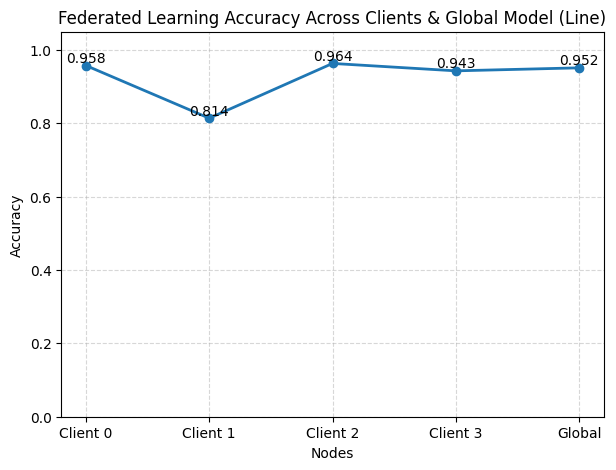

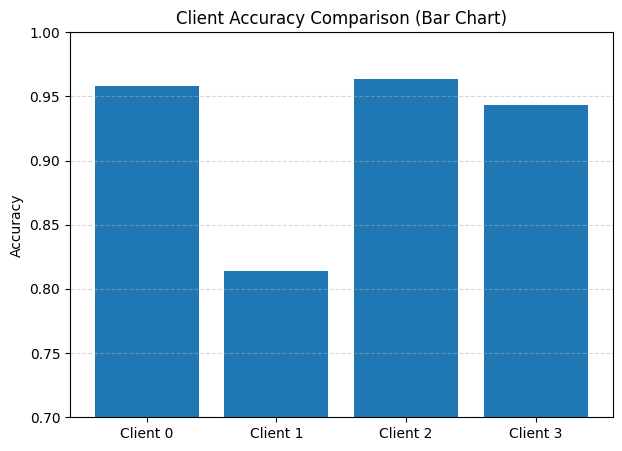

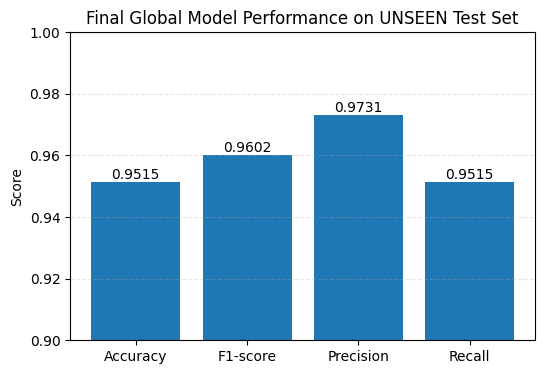

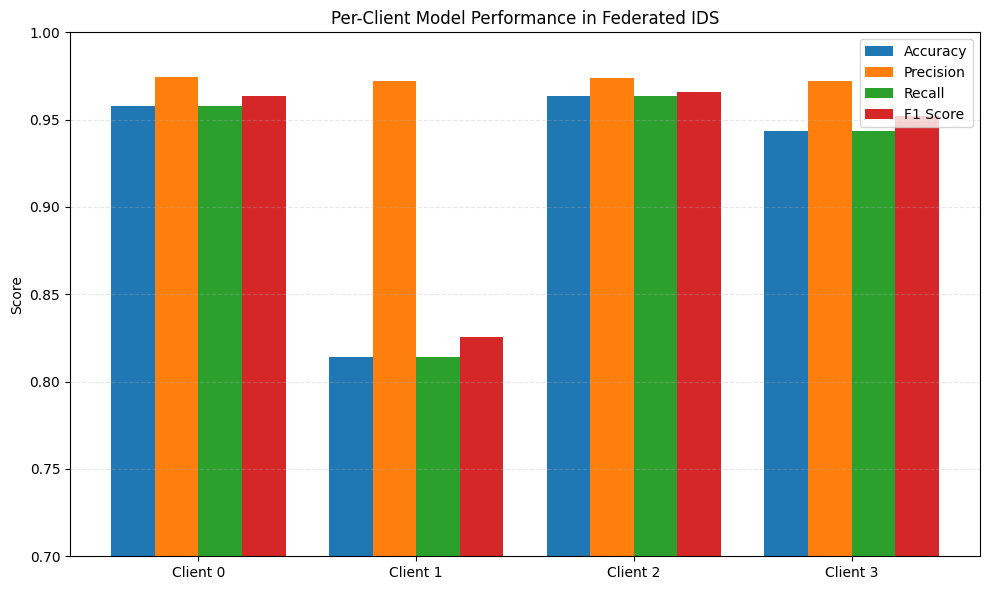

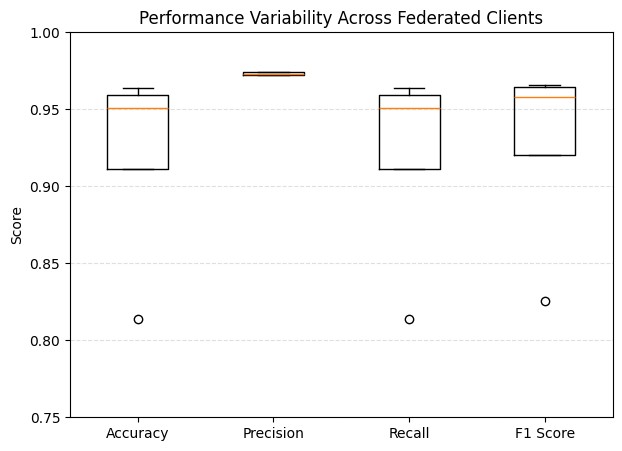

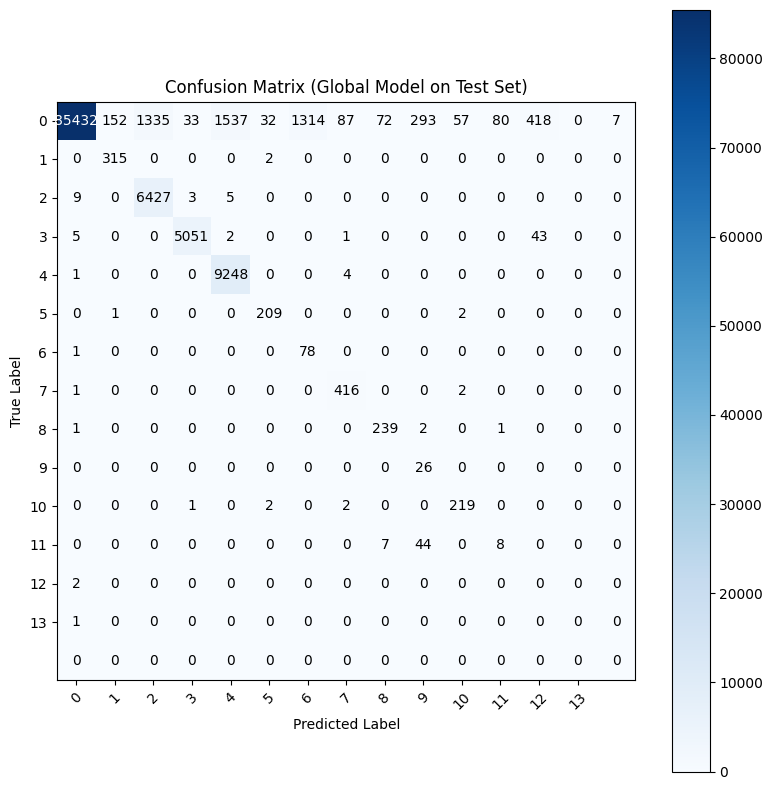

KeyError: "['support'] not found in axis"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import pandas as pd


global_metrics = {
    'Accuracy': 0.9509,
    'F1-score': 0.9601,
    'Precision': 0.9738,
    'Recall': 0.9509
}

clients = ['Client 0', 'Client 1', 'Client 2', 'Client 3']
client_metrics = {
    'Accuracy': [0.9749, 0.9136, 0.9893, 0.9216],
    'Precision': [0.9793, 0.9629, 0.9902, 0.9551],
    'Recall': [0.9749, 0.9136, 0.9893, 0.9216],
    'F1 Score': [0.9754, 0.9169, 0.9883, 0.9229]
}


rounds_acc = clients + ['Global']
accuracy_values = client_metrics['Accuracy'] + [global_metrics['Accuracy']]

plt.figure(figsize=(7, 5))
plt.plot(rounds_acc, accuracy_values, marker='o', linewidth=2)
plt.title("Federated Learning Accuracy Across Clients & Global Model (Line)")
plt.xlabel("Nodes")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
for i, val in enumerate(accuracy_values):
    plt.text(i, val, f"{val:.3f}", ha='center', va='bottom')
plt.show()

plt.figure(figsize=(7, 5))
plt.bar(clients, client_metrics['Accuracy'])
plt.title("Client Accuracy Comparison (Bar Chart)")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


plt.figure(figsize=(6, 4))
plt.bar(global_metrics.keys(), global_metrics.values())
plt.ylabel("Score")
plt.title("Final Global Model Performance on UNSEEN Test Set")
plt.ylim(0.9, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
for i, v in enumerate(global_metrics.values()):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()


x = np.arange(len(clients))
w = 0.2
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*w, client_metrics['Accuracy'], width=w, label='Accuracy')
plt.bar(x - 0.5*w, client_metrics['Precision'], width=w, label='Precision')
plt.bar(x + 0.5*w, client_metrics['Recall'], width=w, label='Recall')
plt.bar(x + 1.5*w, client_metrics['F1 Score'], width=w, label='F1 Score')

plt.xticks(x, clients)
plt.ylabel("Score")
plt.title("Per-Client Model Performance in Federated IDS")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))

plt.boxplot(client_metrics.values(), tick_labels=client_metrics.keys())
plt.title("Performance Variability Across Federated Clients")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(0.75, 1.0)
plt.show()


cm = confusion_matrix(all_labels, all_preds)
classes = np.unique(all_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Global Model on Test Set)")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, cm[i][j], ha='center', va='center',
                 color='white' if cm[i][j] > thresh else 'black')

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).drop(columns=['support']).T.plot(kind='bar', figsize=(12, 6))
plt.title("Classification Report Metrics (Global Model on Test Set)")
plt.ylabel("Score/Value")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()



y_test_bin = label_binarize(all_labels, classes=np.unique(all_labels))
n_classes = y_test_bin.shape[1]

X_test_lstm = X_test_full.reshape(-1, 1, X_test_full.shape[1])
probs = torch.softmax(global_model(torch.tensor(X_test_lstm, dtype=torch.float32)), dim=1).detach().numpy()

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} AUC = {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title("ROC-AUC Curve (Multi-Class, Global Model on Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

print('\\n=== Classification Report Table ===')
print(pd.DataFrame(report))

mlp_multi_metrics_comparison.png


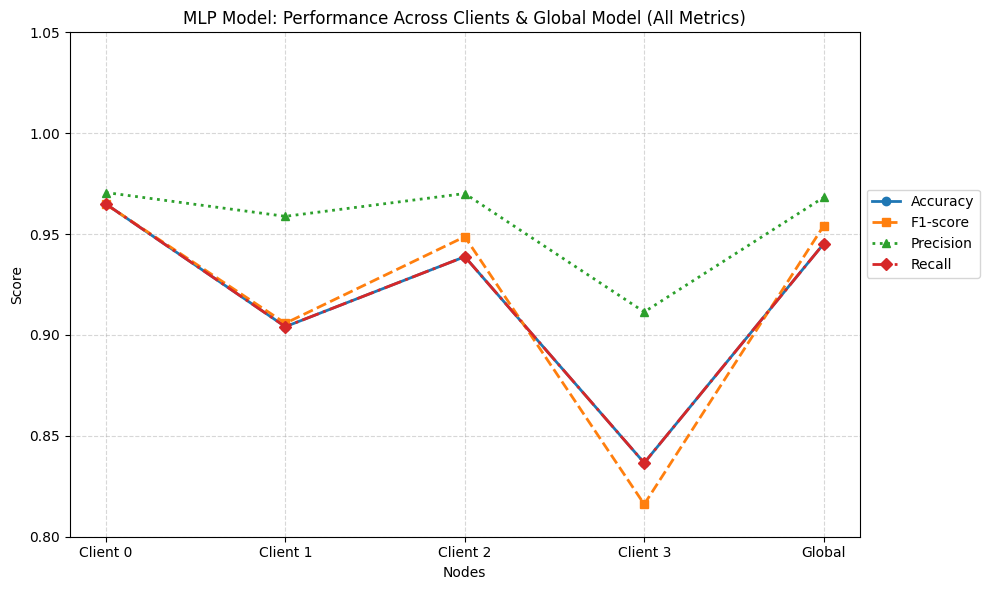

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

nodes = ['Client 0', 'Client 1', 'Client 2', 'Client 3', 'Global']
accuracy = [0.9649, 0.9041, 0.9388, 0.8366, 0.9452]
f1_score = [0.9648, 0.9058, 0.9487, 0.8161, 0.9541]
precision = [0.9706, 0.9588, 0.9701, 0.9114, 0.9682]
recall = [0.9649, 0.9041, 0.9388, 0.8366, 0.9452]

plt.figure(figsize=(10, 6))
plt.plot(nodes, accuracy, marker='o', label='Accuracy', linewidth=2, color='tab:blue', linestyle='-')
plt.plot(nodes, f1_score, marker='s', label='F1-score', linewidth=2, color='tab:orange', linestyle='--')
plt.plot(nodes, precision, marker='^', label='Precision', linewidth=2, color='tab:green', linestyle=':')
plt.plot(nodes, recall, marker='D', label='Recall', linewidth=2, color='tab:red', linestyle='-.')

plt.title("MLP Model: Performance Across Clients & Global Model (All Metrics)")
plt.xlabel("Nodes")
plt.ylabel("Score")
plt.ylim(0.8, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()

plt.savefig('mlp_multi_metrics_comparison.png')
print('mlp_multi_metrics_comparison.png')

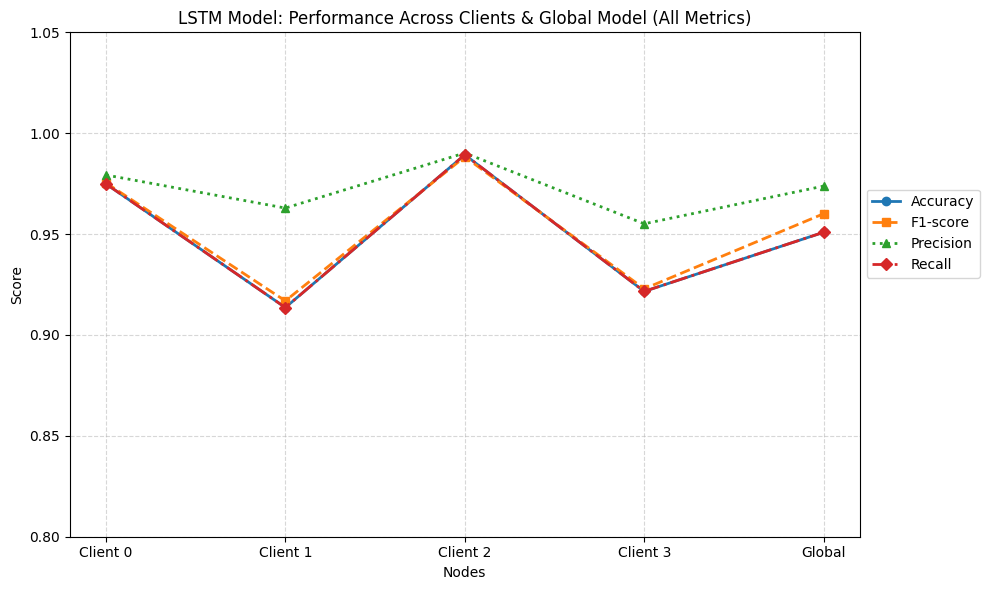

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

nodes = ['Client 0', 'Client 1', 'Client 2', 'Client 3', 'Global']
accuracy = [0.9749, 0.9136, 0.9893, 0.9216, 0.9509]
f1_score = [0.9754, 0.9169, 0.9883, 0.9229, 0.9601]
precision = [0.9793, 0.9629, 0.9902, 0.9551, 0.9738]
recall = [0.9749, 0.9136, 0.9893, 0.9216, 0.9509]

plt.figure(figsize=(10, 6))

plt.plot(nodes, accuracy, marker='o', label='Accuracy', linewidth=2, color='tab:blue', linestyle='-')
plt.plot(nodes, f1_score, marker='s', label='F1-score', linewidth=2, color='tab:orange', linestyle='--')
plt.plot(nodes, precision, marker='^', label='Precision', linewidth=2, color='tab:green', linestyle=':')
plt.plot(nodes, recall, marker='D', label='Recall', linewidth=2, color='tab:red', linestyle='-.')

plt.title("LSTM Model: Performance Across Clients & Global Model (All Metrics)")
plt.xlabel("Nodes")
plt.ylabel("Score")
plt.ylim(0.8, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()

plt.savefig('lstm_multi_metrics_comparison.png')
# print('lstm_multi_metrics_comparison.png')

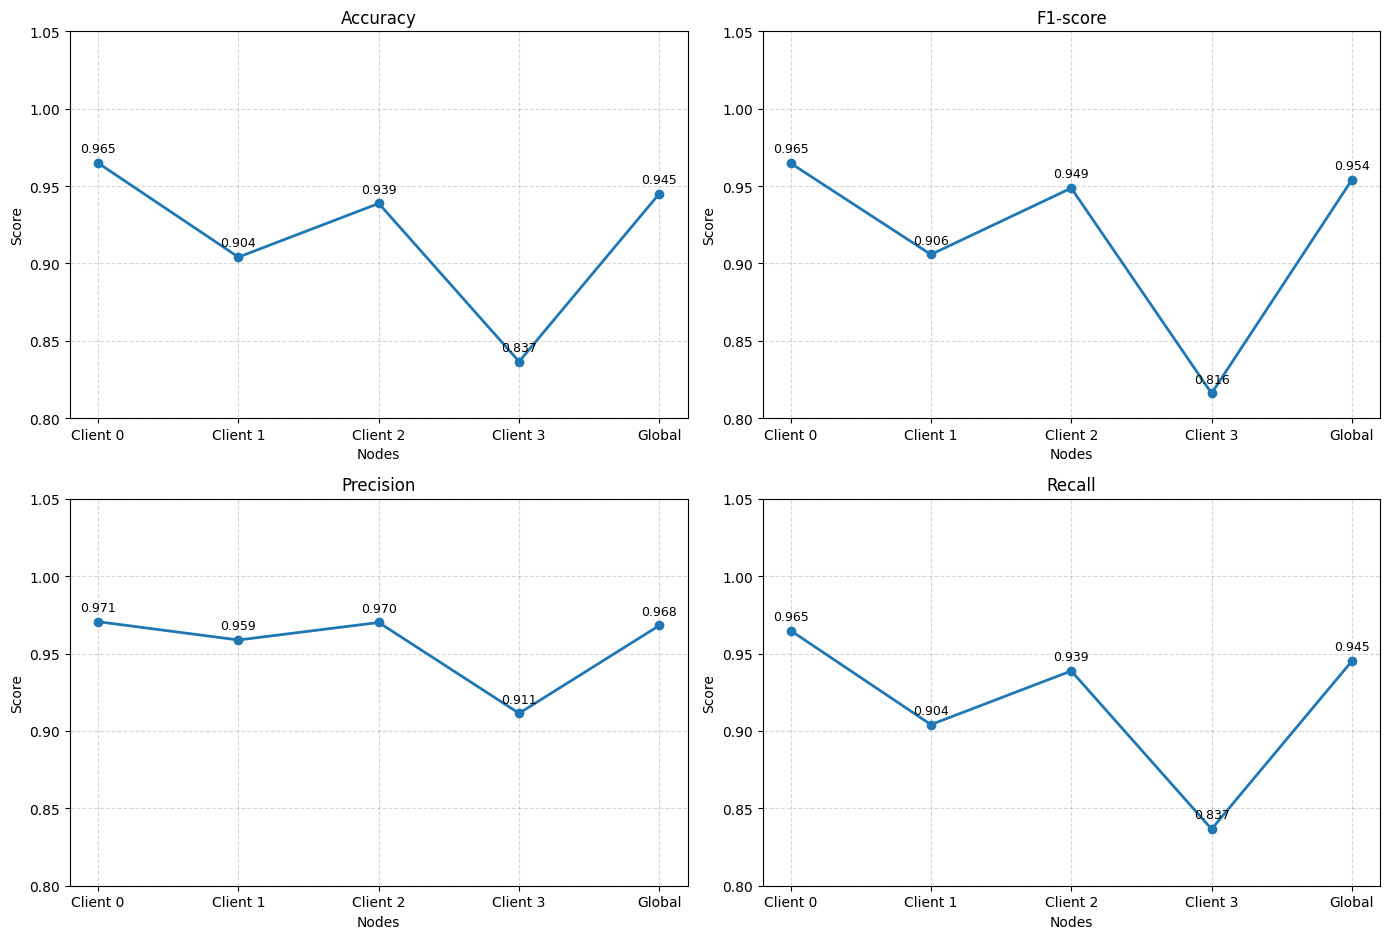

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


nodes = ['Client 0', 'Client 1', 'Client 2', 'Client 3', 'Global']
data = {
    'Accuracy': [0.9649, 0.9041, 0.9388, 0.8366, 0.9452],
    'F1-score': [0.9648, 0.9058, 0.9487, 0.8161, 0.9541],
    'Precision': [0.9706, 0.9588, 0.9701, 0.9114, 0.9682],
    'Recall': [0.9649, 0.9041, 0.9388, 0.8366, 0.9452]
}
df = pd.DataFrame(data, index=nodes)

metrics_list = ['Accuracy', 'F1-score', 'Precision', 'Recall']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()



for i, metric in enumerate(metrics_list):
    ax = axes[i]
    values = df[metric].values

    ax.plot(nodes, values, marker='o', linestyle='-', linewidth=2)

    for x_pos, y_val in enumerate(values):
        ax.text(x_pos, y_val + 0.005, f'{y_val:.3f}', ha='center', va='bottom', fontsize=9)

    ax.set_title(f'{metric}', fontsize=12)
    ax.set_xlabel('Nodes')
    ax.set_ylabel('Score')
    ax.set_ylim(0.8, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

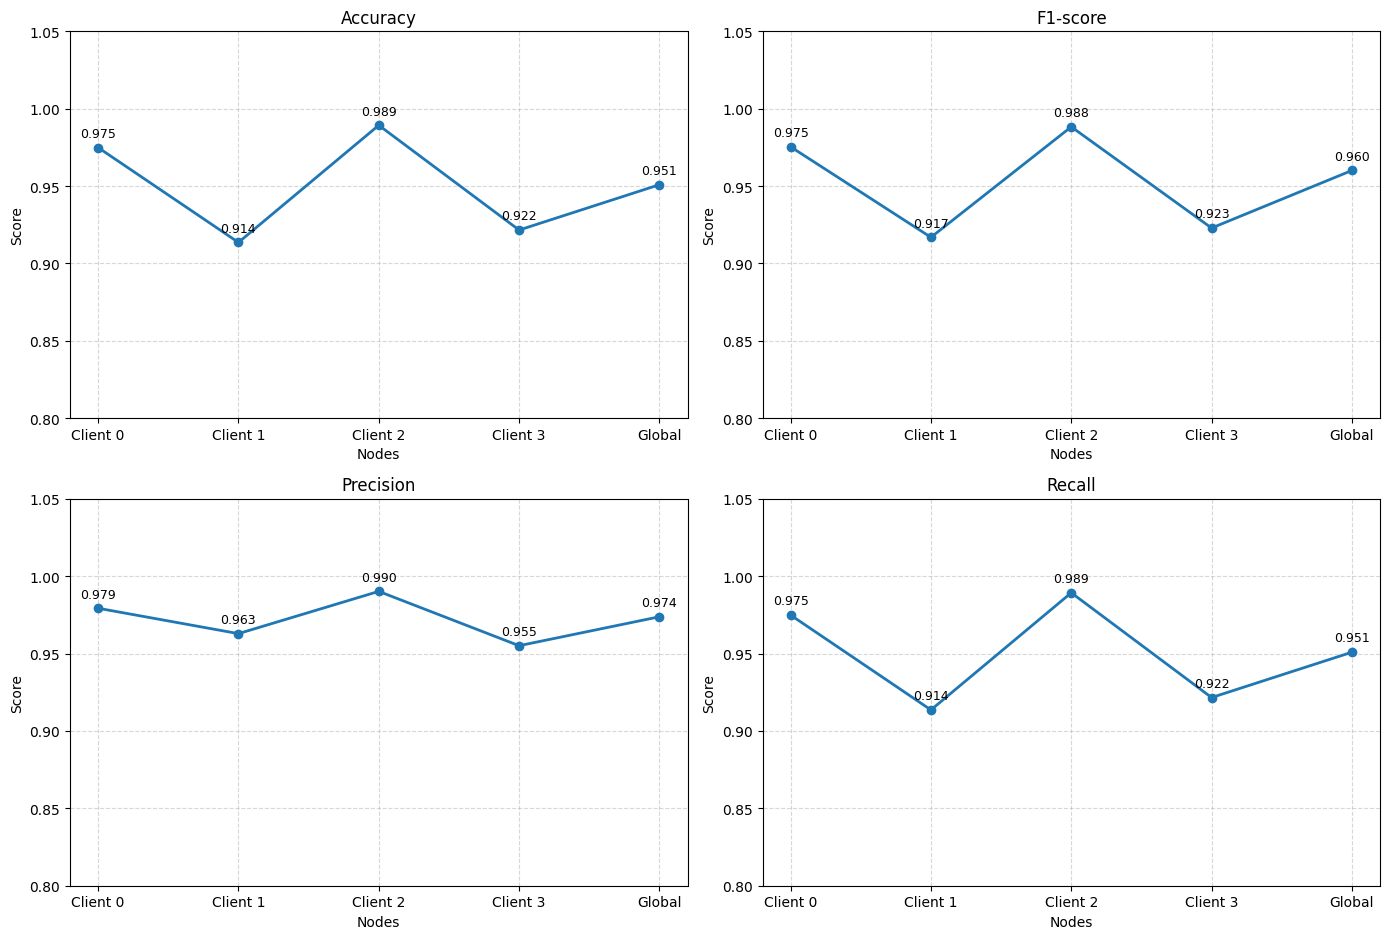

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nodes = ['Client 0', 'Client 1', 'Client 2', 'Client 3', 'Global']
data = {
    'Accuracy': [0.9749, 0.9136, 0.9893, 0.9216, 0.9509],
    'F1-score': [0.9754, 0.9169, 0.9883, 0.9229, 0.9601],
    'Precision': [0.9793, 0.9629, 0.9902, 0.9551, 0.9738],
    'Recall': [0.9749, 0.9136, 0.9893, 0.9216, 0.9509]
}
df = pd.DataFrame(data, index=nodes)

metrics_list = ['Accuracy', 'F1-score', 'Precision', 'Recall']


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_list):
    ax = axes[i]
    values = df[metric].values

    ax.plot(nodes, values, marker='o', linestyle='-', linewidth=2)

    for x_pos, y_val in enumerate(values):
        ax.text(x_pos, y_val + 0.005, f'{y_val:.3f}', ha='center', va='bottom', fontsize=9)


    ax.set_title(f'{metric}', fontsize=12)
    ax.set_xlabel('Nodes')
    ax.set_ylabel('Score')
    ax.set_ylim(0.8, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

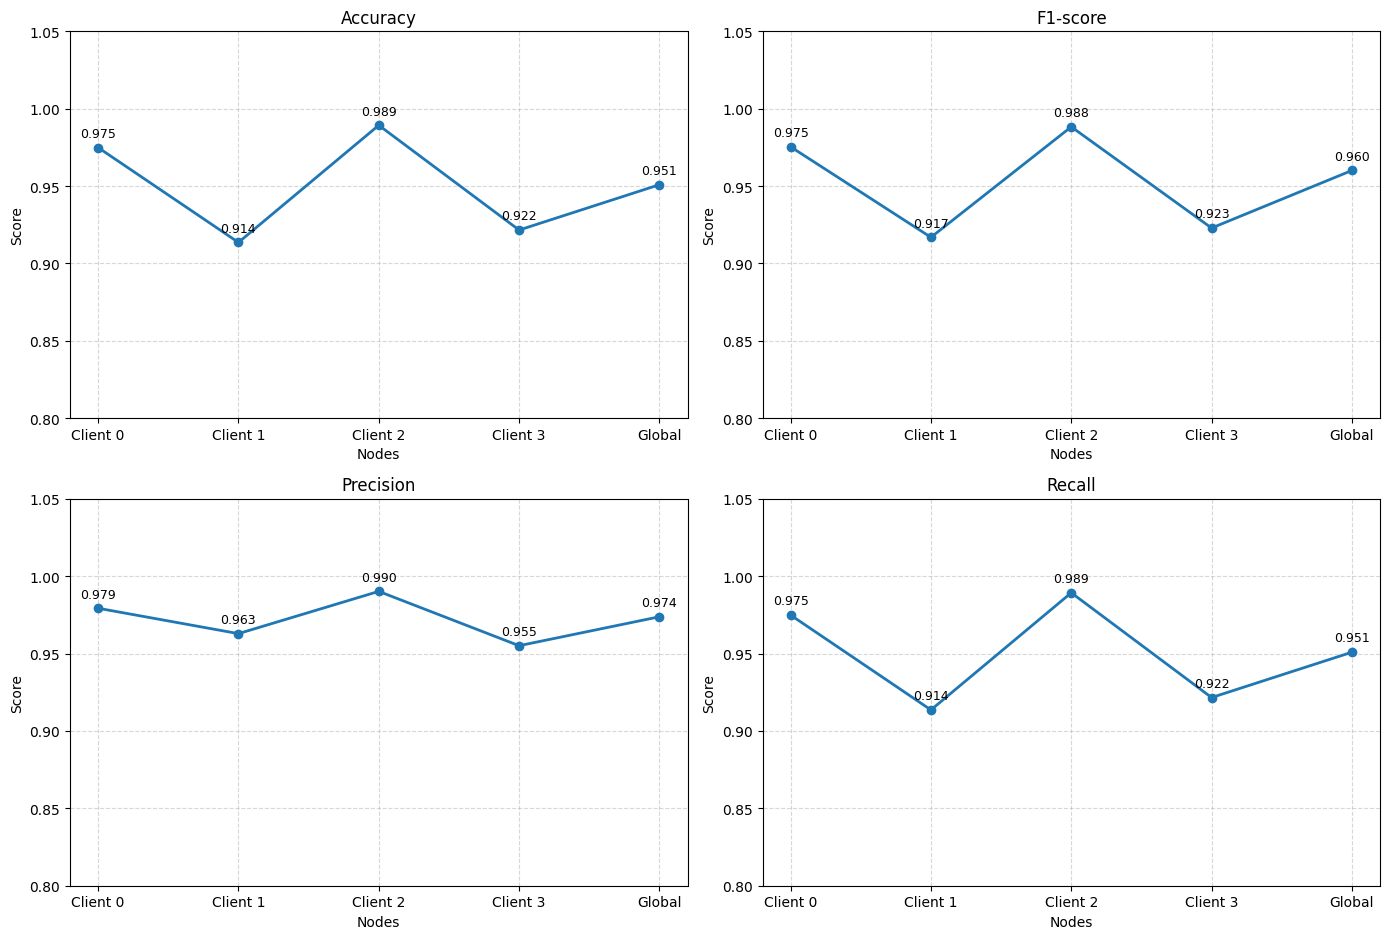

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nodes = ['Client 0', 'Client 1', 'Client 2', 'Client 3', 'Global']
data = {
    'Accuracy': [0.9749, 0.9136, 0.9893, 0.9216, 0.9509],
    'F1-score': [0.9754, 0.9169, 0.9883, 0.9229, 0.9601],
    'Precision': [0.9793, 0.9629, 0.9902, 0.9551, 0.9738],
    'Recall': [0.9749, 0.9136, 0.9893, 0.9216, 0.9509]
}
df_lstm = pd.DataFrame(data, index=nodes)

metrics_list = ['Accuracy', 'F1-score', 'Precision', 'Recall']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, metric in enumerate(metrics_list):
    ax = axes[i]
    values = df_lstm[metric].values

    ax.plot(nodes, values, marker='o', linestyle='-', linewidth=2)

    for x_pos, y_val in enumerate(values):
        ax.text(x_pos, y_val + 0.005, f'{y_val:.3f}', ha='center', va='bottom', fontsize=9)

    ax.set_title(f'{metric}', fontsize=12)
    ax.set_xlabel('Nodes')
    ax.set_ylabel('Score')
    ax.set_ylim(0.8, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()